In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

Display results

In [2]:
def print_accuracy(predicted_labels, val_labels):
    accuracy = np.mean(predicted_labels == val_labels)
    accuracy = max(accuracy, 1. - accuracy)
    print(f'Accuracy: {accuracy * 100:.2f}%')

def print_auroc(scores, val_labels):
    auroc = max(roc_auc_score(val_labels, scores),roc_auc_score(val_labels, -1* scores)) 
    print(f'AUROC: {auroc * 100:.2f}%')

In [3]:
def plot_sorted(anomaly_scores, anomaly_labels, title = 'Sorted Numerical Scores'):
    # Get the indices that would sort the scores
    sorted_indices = np.argsort(anomaly_scores)
    
    # Sort both the scores and the prediction labels by the sorted indices
    sorted_scores = anomaly_scores[sorted_indices]
    anomaly_labels = anomaly_labels[sorted_indices]
    
    # Create corresponding indices for plotting
    anomaly_indices = np.where(anomaly_labels == 1)[0]
    good_indices = np.where(anomaly_labels == 0)[0]

    # Plot the sorted scores
    anomalies = sorted_scores[anomaly_labels==1]
    goodones = sorted_scores[anomaly_labels==0]

    plt.scatter(good_indices, goodones, color='b', marker='x', label='Good Ones', alpha=0.2)
    plt.scatter(anomaly_indices, anomalies, color='r', marker='+', label='Anomalies', alpha=0.8)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Score')
    plt.title(title)

    # Show the plot
    plt.show()


Load the data

In [4]:
name = "testCase0"
data = np.load(name+".npy")
labels = np.load(name+"_labels.npy")
K = data.shape[0]
N = data.shape[1]
data.shape

(10000, 500)

### K-Means Clustering

In [5]:
# Standardize the data (important for KMeans)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Use KMeans to find clusters, we choose k=2 for binary classification
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_scaled)

# Predict training cluster labels
cluster_labels = kmeans.predict(data_scaled)
cluster_distances = kmeans.transform(data_scaled)

In [6]:
print("# bad elements: "+ str(np.count_nonzero(cluster_labels)))
print_accuracy(cluster_labels, labels)
print_auroc(cluster_distances[:,0], labels)

# bad elements: 3443
Accuracy: 64.49%
AUROC: 99.56%


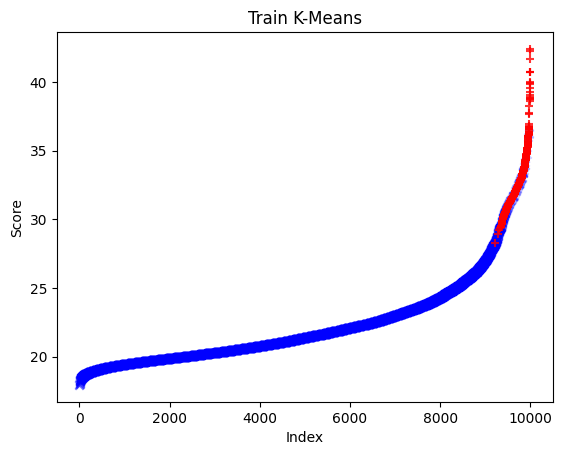

In [7]:
plot_sorted(cluster_distances[:,0], labels, "Train K-Means")

In [8]:
name = "val_testCase0"
val_data = np.load(name+".npy")
val_labels = np.load(name+"_labels.npy")
val_data.shape

(1000, 500)

In [9]:
val_data_scaled = scaler.transform(val_data)
val_cluster_labels = kmeans.predict(val_data_scaled)
val_cluster_distances = kmeans.transform(val_data_scaled)  

In [10]:
print("# bad elements: "+ str(np.count_nonzero(val_cluster_labels)))
print_accuracy(val_cluster_labels, val_labels)
print_auroc(val_cluster_distances[:,0], val_labels)

# bad elements: 411
Accuracy: 57.10%
AUROC: 77.83%


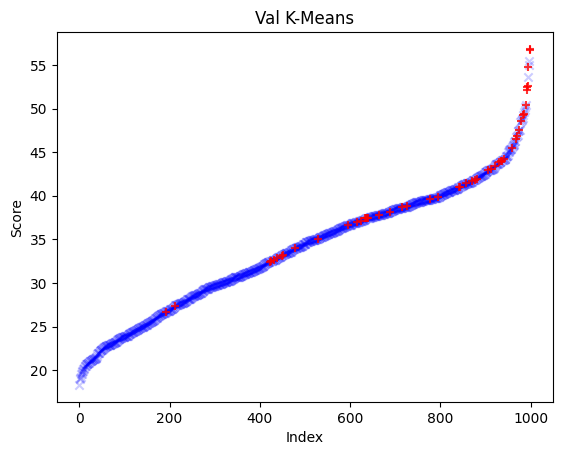

In [11]:
plot_sorted(val_cluster_distances[:,0], val_labels, "Val K-Means")

Check if oversampling helps

In [12]:
# Separate majority and minority classes
good_data = data_scaled[labels == 0]
bad_data = data_scaled[labels == 1]

good_labels = labels[labels == 0]
bad_labels = labels[labels == 1]

# Oversample the minority class (bad_data)
bad_data_oversampled, bad_labels_oversampled = resample(bad_data, bad_labels,
                                                        replace=True,  # Allow resampling with replacement
                                                        n_samples=len(good_data),  # Match the number of "good" data points
                                                        random_state=42)

# Combine the oversampled data with the majority class data
data_oversampled = np.vstack((good_data, bad_data_oversampled))
labels_oversampled = np.hstack((good_labels, bad_labels_oversampled))

# Shuffle the data to ensure random ordering
indices = np.random.permutation(len(labels_oversampled))
data_oversampled = data_oversampled[indices]
labels_oversampled = labels_oversampled[indices]

In [13]:
# Use KMeans to find clusters, we choose k=2 for binary classification
kmeans_oversampled = KMeans(n_clusters=2, random_state=42)
kmeans_oversampled.fit(data_oversampled)

# Predict training cluster labels
cluster_labels_oversampled = kmeans_oversampled.predict(data_oversampled)
cluster_distances_oversampled = kmeans_oversampled.transform(data_oversampled)

In [14]:
print("# bad elements: "+ str(np.count_nonzero(cluster_labels_oversampled)))
print_accuracy(cluster_labels_oversampled, labels_oversampled)
print_auroc(cluster_distances_oversampled[:,0], labels_oversampled)

# bad elements: 9500
Accuracy: 100.00%
AUROC: 99.93%


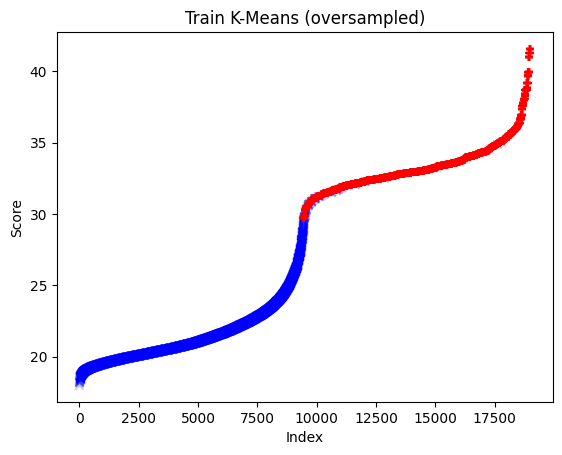

In [15]:
plot_sorted(cluster_distances_oversampled[:,0], labels_oversampled, "Train K-Means (oversampled)")

In [16]:
val_cluster_labels_oversampled = kmeans_oversampled.predict(val_data_scaled)
val_cluster_distances_oversampled = kmeans_oversampled.transform(val_data_scaled)

In [17]:
print("# bad elements: "+ str(np.count_nonzero(val_cluster_labels_oversampled)))
print_accuracy(val_cluster_labels_oversampled, val_labels)
print_auroc(val_cluster_distances_oversampled[:,0], val_labels)

# bad elements: 88
Accuracy: 95.80%
AUROC: 80.95%


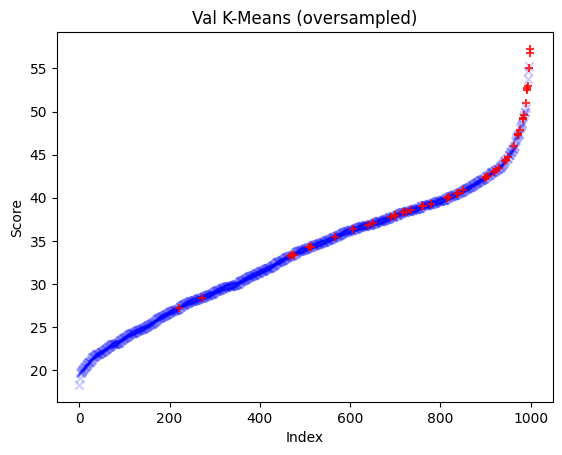

In [18]:
plot_sorted(val_cluster_distances_oversampled[:,0], val_labels, "Val K-Means (oversampled)")

### Isolation Forest

In [19]:
#keep orig to calculate training accuracies
orig_data = data.copy()
#now shuffle the data to make sure order doesn't matter
np.random.shuffle(data)
data.shape

(10000, 500)

In [20]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Assume 5% of the data is "bad"
iso_forest.fit(data)

IsolationForest(contamination=0.05, random_state=42)

In [21]:
# Predict: -1 for anomalies (bad time series), 1 for normal data (good time series)
train_predictions = iso_forest.predict(orig_data)
# Convert predictions: -1 (anomaly) -> 1 (bad), 1 (normal) -> 0 (good)
train_prediction_labels = np.where(train_predictions == -1, 1, 0)
# Get scores
train_anomaly_scores = iso_forest.decision_function(orig_data)

In [22]:
print("# bad elements: "+ str(np.count_nonzero(train_prediction_labels)))
print_accuracy(train_prediction_labels, labels)
print_auroc(train_anomaly_scores, labels)

# bad elements: 500
Accuracy: 98.68%
AUROC: 99.69%


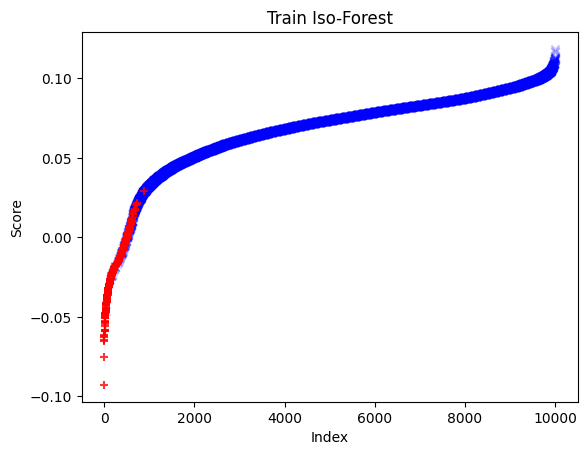

In [23]:
plot_sorted(train_anomaly_scores, labels, "Train Iso-Forest")

In [24]:
predictions = iso_forest.predict(val_data)
prediction_labels = np.where(predictions == -1, 1, 0)
anomaly_scores = iso_forest.decision_function(val_data)

In [25]:
print("# bad elements: "+ str(np.count_nonzero(prediction_labels)))
print_accuracy(prediction_labels, val_labels)
print_auroc(anomaly_scores, val_labels)

# bad elements: 594
Accuracy: 54.80%
AUROC: 85.77%


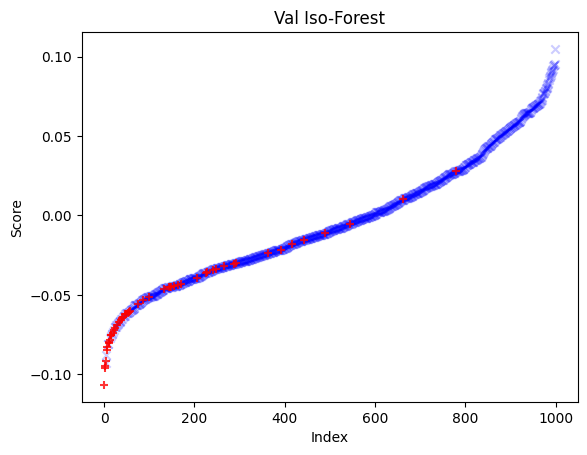

In [26]:
plot_sorted(anomaly_scores, val_labels, "Val Iso-Forest")

### One-Class SVM

In [27]:
svm = OneClassSVM(nu=0.05, kernel="rbf")  # nu is the proportion of outliers
svm.fit(data)

train_predictions = svm.predict(orig_data)
train_prediction_labels = np.where(train_predictions == -1, 1, 0)
train_anomaly_scores = svm.decision_function(orig_data)

In [28]:
print("# bad elements: "+ str(np.count_nonzero(train_prediction_labels)))
print_accuracy(train_prediction_labels, labels)
print_auroc(train_anomaly_scores, labels)

# bad elements: 501
Accuracy: 93.99%
AUROC: 91.22%


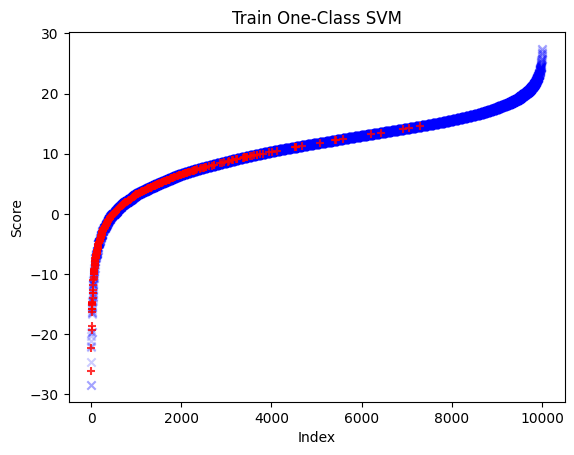

In [29]:
plot_sorted(train_anomaly_scores, labels, "Train One-Class SVM")

In [30]:
predictions = svm.predict(val_data)
prediction_labels = np.where(predictions == -1, 1, 0)
anomaly_scores = svm.decision_function(val_data)

In [31]:
print("# bad elements: "+ str(np.count_nonzero(prediction_labels)))
print_accuracy(prediction_labels, val_labels)
print_auroc(anomaly_scores, val_labels)

# bad elements: 849
Accuracy: 80.30%
AUROC: 55.79%


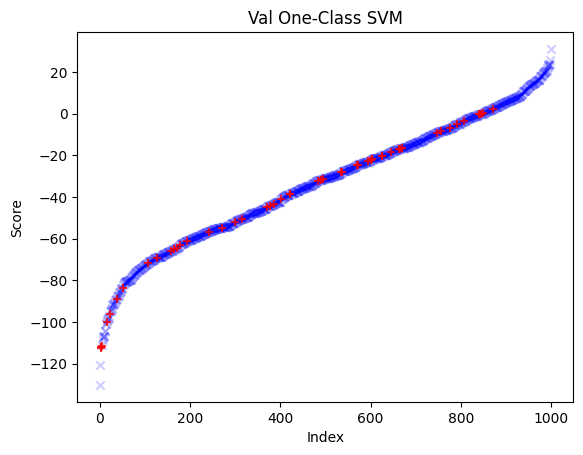

In [32]:
plot_sorted(anomaly_scores, val_labels, "Val One-Class SVM")

### Leverage statistics

In [33]:
X=val_data
N=val_data.shape[0]
P=val_data.shape[1]

Leverage statistics $h_{ii}$ of ${x}_{i}$ is $\mathbf {H}_{ii}$ with ${\displaystyle \mathbf {H} =\mathbf {X} \left(\mathbf {X} ^{\top }\mathbf {X} \right)^{-1}\mathbf {X} ^{\top }}$

In [34]:
XT = np.transpose(X)
XTX = np.matmul(XT, X)
XTXI = np.linalg.inv(XTX)
XXTXI = np.matmul(X, XTXI)
H = np.matmul(XXTXI, XT)
Hi = np.diagonal(H)

If $h_{ii}>2{\dfrac {p}{n}}$ then ${x}_{i}$ shall be considered an outlier.

In [35]:
prediction_labels = np.where(Hi > 2*P/N, 1, 0)

In [36]:
print("# bad elements: "+ str(np.count_nonzero(prediction_labels)))
print_accuracy(prediction_labels, val_labels)
print_auroc(anomaly_scores, val_labels)

# bad elements: 0
Accuracy: 95.00%
AUROC: 55.79%


### Local Outlier Factor (LOF)

In [37]:
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.05)
lof.fit(data)

train_predictions = lof.predict(orig_data)
train_prediction_labels = np.where(train_predictions == -1, 1, 0)
train_anomaly_scores = lof.decision_function(orig_data)

In [38]:
print("# bad elements: "+ str(np.count_nonzero(train_prediction_labels)))
print_accuracy(train_prediction_labels, labels)
print_auroc(train_anomaly_scores, labels)

# bad elements: 454
Accuracy: 93.98%
AUROC: 64.56%


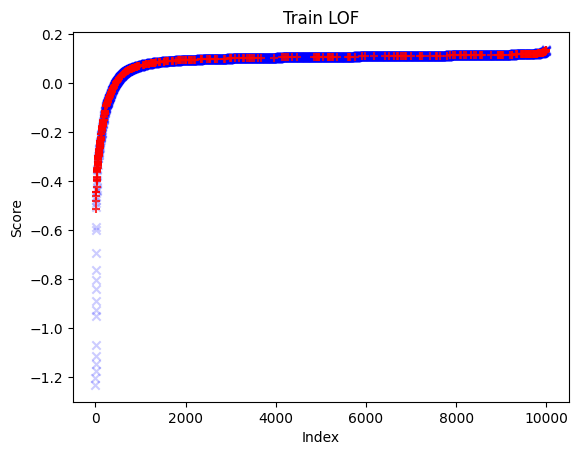

In [39]:
plot_sorted(train_anomaly_scores, labels, "Train LOF")

In [40]:
predictions = lof.predict(val_data)
prediction_labels = np.where(predictions == -1, 1, 0)
anomaly_scores = lof.decision_function(val_data)

In [41]:
print("# bad elements: "+ str(np.count_nonzero(prediction_labels)))
print_accuracy(prediction_labels, val_labels)
print_auroc(anomaly_scores, val_labels)

# bad elements: 903
Accuracy: 86.30%
AUROC: 50.93%


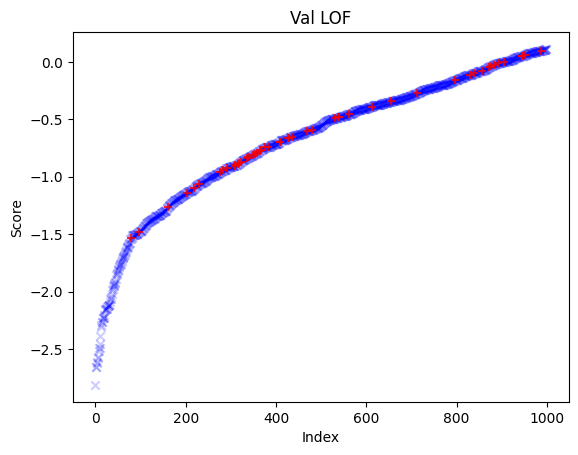

In [42]:
plot_sorted(anomaly_scores, val_labels, "Val LOF")